In [1]:
import pandas as pd
import numpy as np

RSEED = 42
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')


import tensorflow as tf
tf.random.set_seed(RSEED)
from tensorflow.keras.layers import Concatenate

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score  


from survive import SurvivalData
from survive import KaplanMeier



import sys
sys.path.append('/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/AE')
import models, run_models

sys.path.append('/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/helper_functions')
import helpers, clustering_helpers


import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)





2023-11-16 12:24:24.375917: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In  models file
Using TensorFlow backend
In run_models python file


In [2]:
import warnings
warnings.filterwarnings("ignore")

### Read the datasets 

In [3]:
time_series_2d = np.load('preprocessing/representations/time_series_2d_scaled.npy')
time_series_3d = np.load('preprocessing/representations/time_series_3d_scaled.npy')

static = pd.read_csv('preprocessing/representations/static_eq.csv')
time_series_2d_df = pd.read_csv('preprocessing/representations/time_series_2d_scaled_df.csv')
time_series_3d_df = pd.read_csv('preprocessing/representations/time_series_3d.csv')


folder_sepsis = 'sepsis3_queries/data'
sepsis3 = pd.read_csv(f'{folder_sepsis}/sepsis-df-3.csv')

In [4]:
time_series_2d.shape

(5784, 24, 47)

In [5]:
time_series_3d.shape

(5784, 24, 47)

In [6]:
time_series_2d_df = time_series_2d_df.set_index('icustay_id')

time_series_2d_df.shape

(5784, 47)

In [7]:
print('static shape before dropping empty values', static.shape)

static = static.loc[:, static.gt(0).mean() >= .1]
print('static shape after dropping empty values', static.shape)


static shape before dropping empty values (5784, 52)
static shape after dropping empty values (5784, 32)


In [8]:
static = static.set_index('icustay_id')

#sepsis3
static = static[['vent', 'F', 'M', 'adults', 'seniors', 'race_white', 'race_other',
    'gcs_13_15', 'gcs_9_12', 'gcs_<8', 'congestive_heart_failure',
    'cardiac_arrhythmias', 'hypertension', 'other_neurological',
    'chronic_pulmonary',  'hypothyroidism',
    'renal_failure', 'liver_disease', 'coagulopathy', 'fluid_electrolyte',
    'alcohol_abuse', 'depression', 'diabetes', 'circulatory',
    'circulatory_infectious_congenital', 'nervous_and_sense',
    'endocrinal_nutritional', 'neoplasms', 'blood_and_blood_forming',
    'mental']]
    
static.shape

(5784, 30)

In [9]:

time_series_3d = time_series_3d.astype(np.float32)
static = static.astype(float)


## Load models

In [10]:
static = static.fillna(0)

In [11]:
## load the encoded representations

path = f'results_EQ/saved_models' 
latent_ts, latent_st, latent_mm = helpers.load_encoded_spaces(time_series_3d, static, 'latent_4(3)_EQ', path)
#helpers.

181/181 [==============================] - 1s 2ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 3s 7ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 3s 8ms/step
MM SHAPE: (5784, 10)


## Multiple runs model

In [ ]:
from tqdm import tqdm

path = f'results_EQ/saved_models_avg' 
num_runs = 10
all_encoded_static = []
all_encoded_time_series = []
all_encoded_mm = []

for run in tqdm(range(num_runs), desc="Training Autoencoders"):
    current_seed = RSEED + run  # Use a different seed for each run
    tf.random.set_seed(current_seed)
    np.random.seed(current_seed)
    print(run, current_seed)

    latent_ts, latent_st, latent_mm = helpers.load_encoded_spaces(time_series_3d, static, f'latent_avg_{run}', path)
    all_encoded_static.append(latent_st)
    all_encoded_time_series.append(latent_ts)
    all_encoded_mm.append(latent_mm)
    
# Compute the average of the encoded representations
average_encoded_static = np.mean(all_encoded_static, axis=0)
average_encoded_time_series = np.mean(all_encoded_time_series, axis=0)
average_encoded_mm = np.mean(all_encoded_mm, axis=0)



## Baselines


HDBSCAN
Best Parameters: {'min_cluster_size': 30, 'min_samples': 2}
Best Silhouette Score: -0.06936617
K-PROTOTYPES
HIERARCHICAL
CONSENSUS
optimal k ts:  3
optimal k static:  3
3


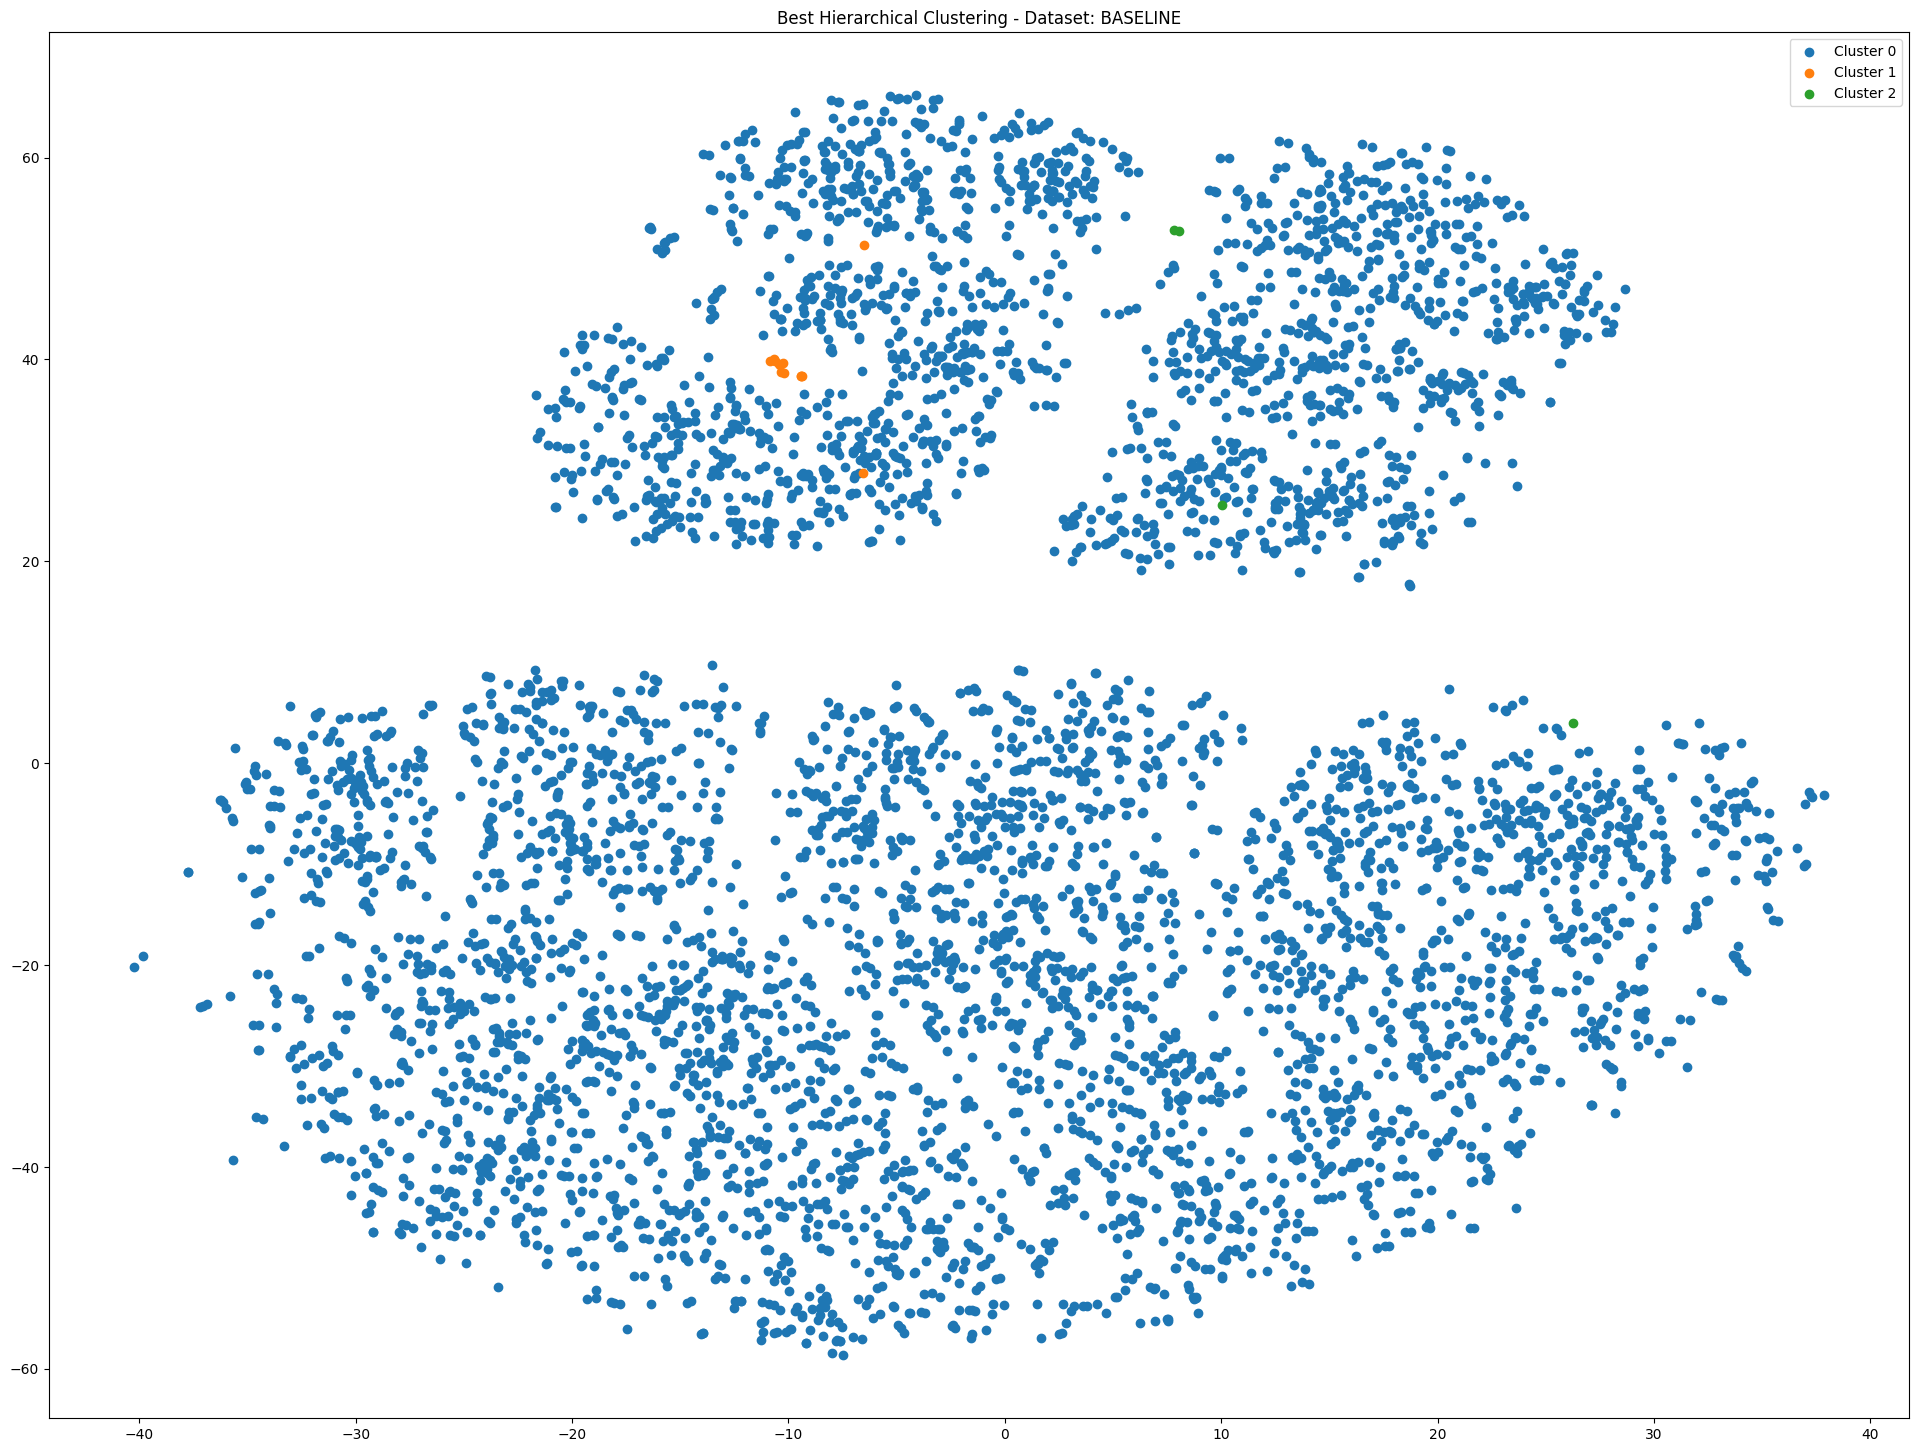

In [12]:
bool_list = [True] * len(static.columns) + [False] * len(time_series_2d_df.columns) 

#time series should be false
best_method_baseline, best_silhouette_score_baseline, best_model_baseline, results_df_baseline, best_labels_baseline = \
    clustering_helpers.compare_clustering_methods_baselines(static, time_series_2d_df, bool_list, 'BASELINE', max_clusters=5)

In [13]:
results_df_baseline

,Model,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,HDBSCAN_gower,-0.069366,1.868086,706.228964
1,Hierarchical_gower,0.237084,1.761684,31.122245
2,K-Prototypes,0.146022,2.494124,848.845689
3,Consensus,0.097245,2.932797,559.315286
4,Consensus_ts,0.027066,9.175228,184.115450
5,Consensus_static,0.064825,3.149413,318.142116


In [14]:
np.bincount(best_labels_baseline)

array([5766,   14,    4])

## Comparison of fusions 

KMeans
SPectral
{'min_cluster_size': 60, 'min_samples': 2}
Agglomerative
The model with the maximum silhouette score is: Agglomerative
kmeans:  15
hdbscan:  16
agglomerative:  40


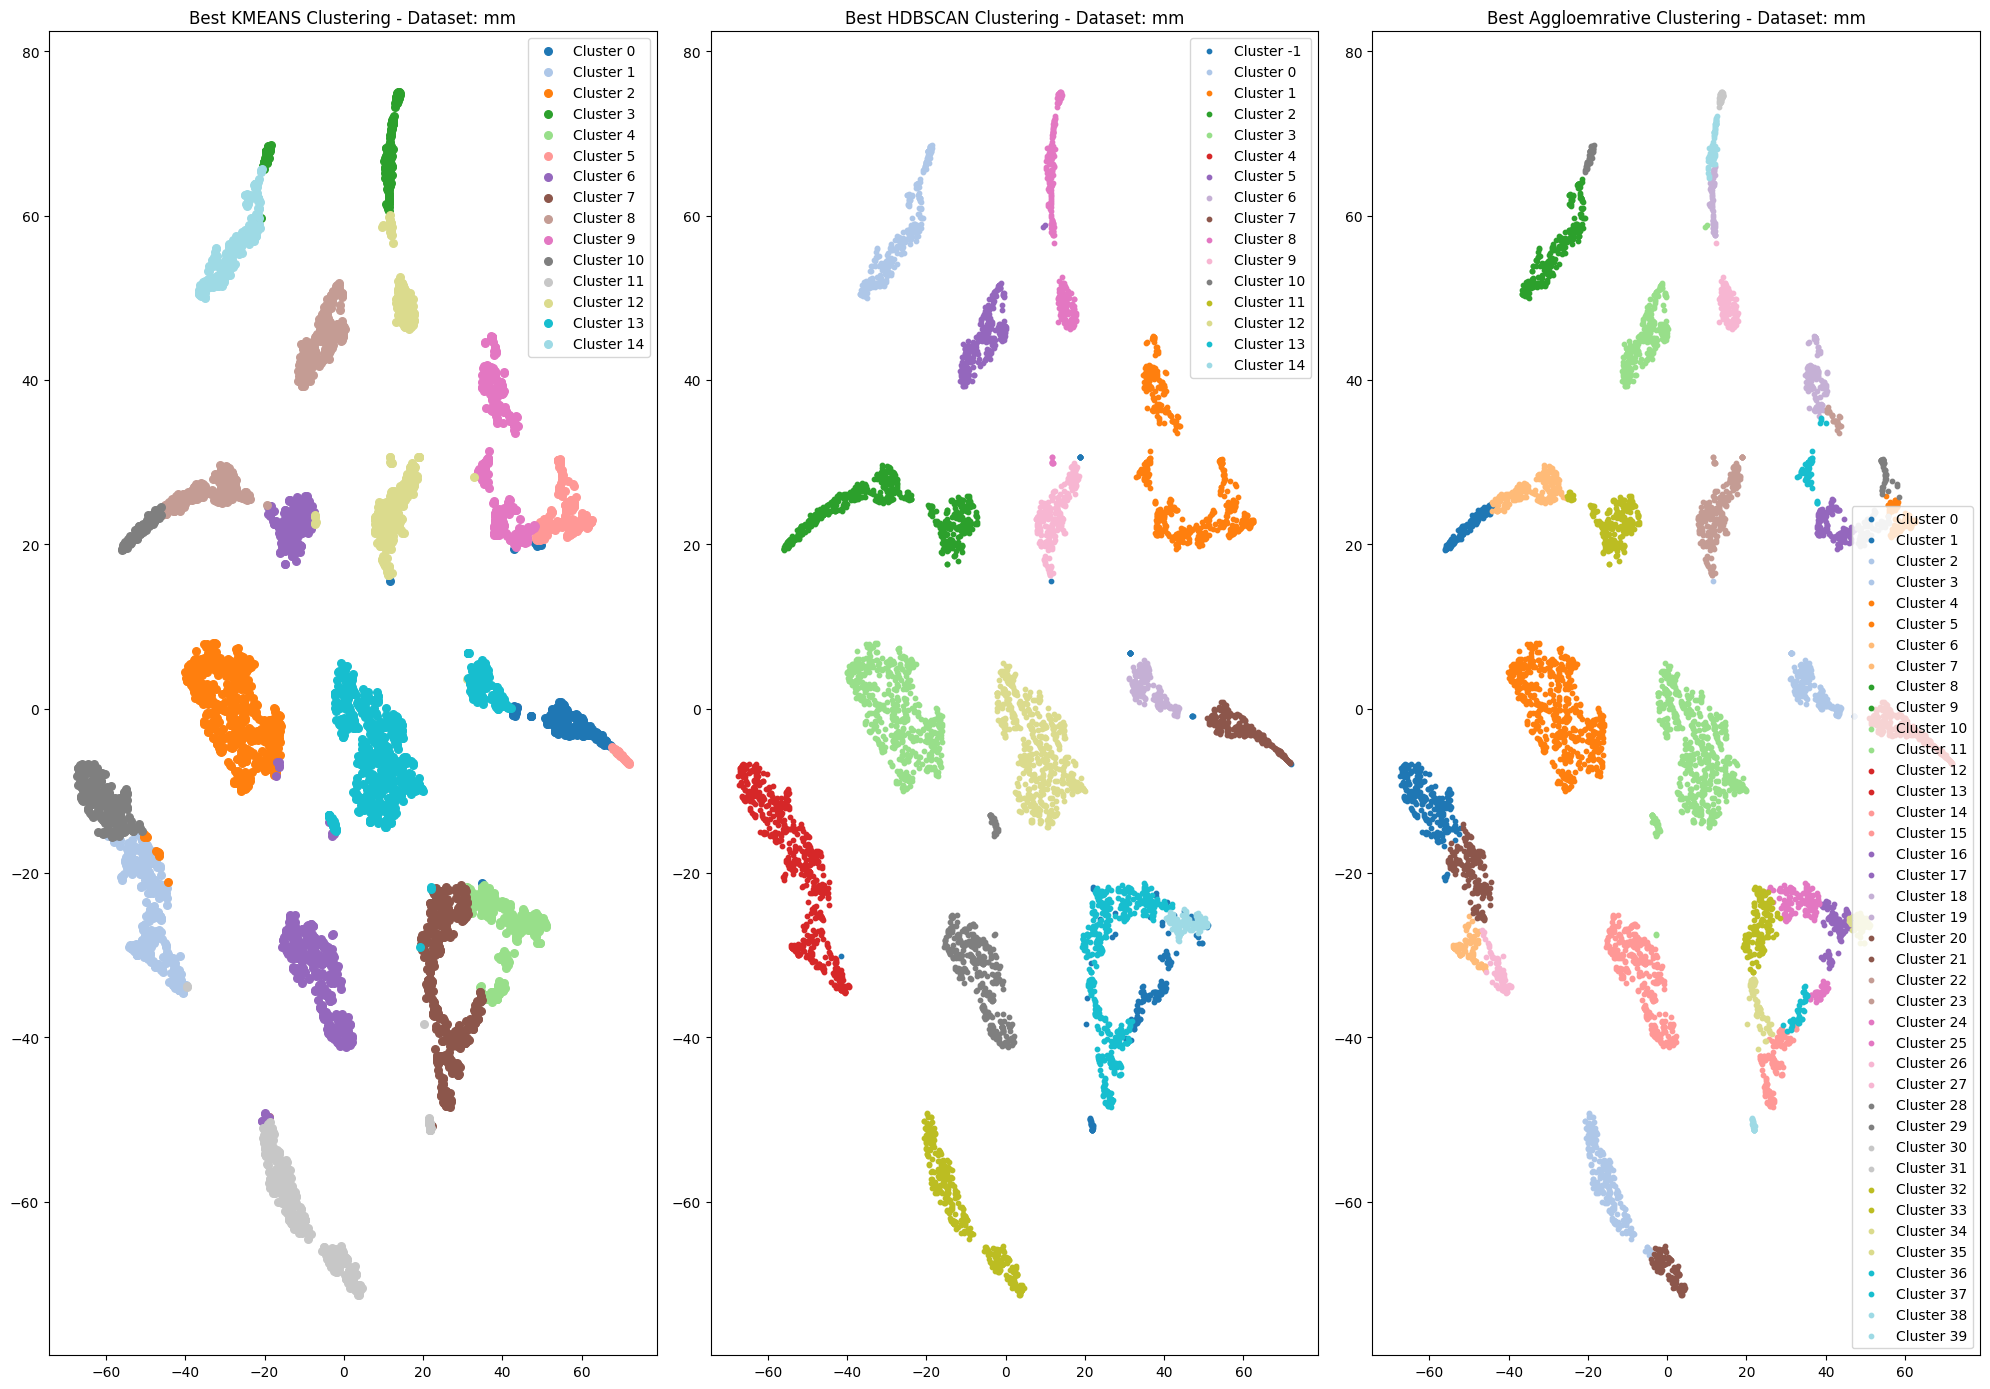

In [16]:
latent_late_fusion = Concatenate()([latent_ts, latent_st])
latent_late_fusion = np.array(latent_late_fusion)
#average_late_fusion = Concatenate()([average_encoded_static, average_encoded_static])
#average_late_fusion = np.array(average_late_fusion)
data = [latent_mm]
#average_encoded_static, average_encoded_time_series, average_encoded_mm, average_late_fusion
#latent_st, latent_ts, latent_mm, latent_late_fusion
dataset_name = [ 'mm']
#'st', 'ts', 'mm', 'lf'
#'encoded_static', 'encoded_time_series', 
# data = [encoded_mm, encoded_late_fusion]

results = pd.DataFrame()
best_labels = pd.DataFrame()
all_labels = pd.DataFrame()
for i, y in zip(data, dataset_name):
    df_results, best_labels_, labels_df, best_model = clustering_helpers.compare_kmeans_hdbscan(i, dataset_name = y,  max_k=100)

    df_results.index = [y, y, y]

    y = f'{y}_{best_model}'
    labels_ = pd.Series(best_labels_, name=y)
    best_labels = pd.concat([best_labels, labels_], axis=1)
    all_labels = pd.concat([all_labels, labels_df], axis=1)
    

    #results = results.append(df_results)
    results = pd.concat([results, df_results])

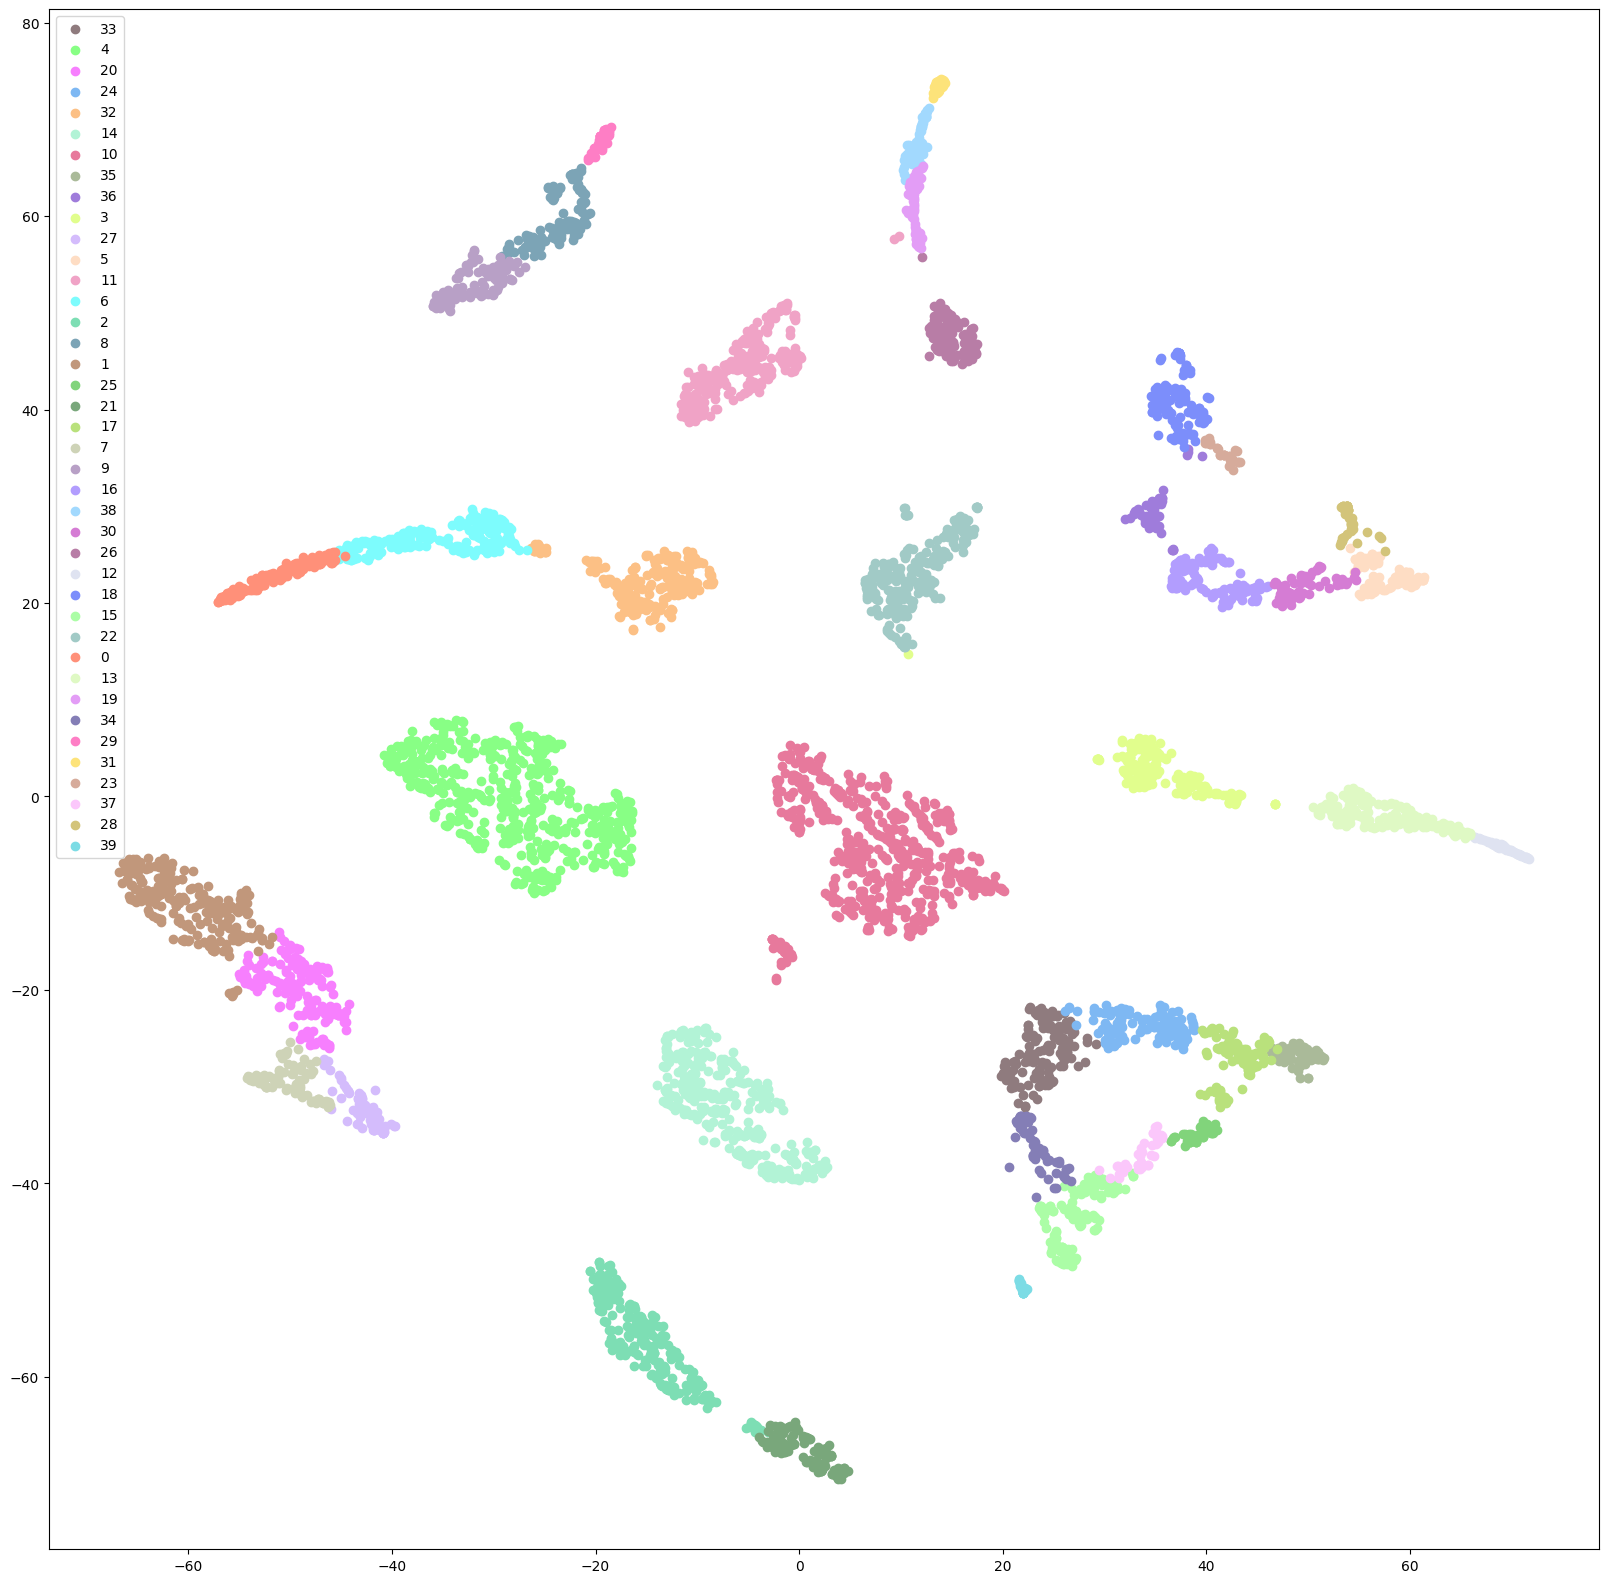

In [35]:
from sklearn.manifold import TSNE
import distinctipy

best_reduced_data = TSNE(n_components=2, random_state=2, perplexity=50).fit_transform(latent_mm) 
plt.figure(figsize=(20, 20))

# Get unique categories and corresponding colors
unique_categories = best_labels['mm_Agglomerative'].unique()
num_categories = len(unique_categories)

# number of colours to generate
N = 40

# generate N visually distinct colours
colors = distinctipy.get_colors(N, pastel_factor=0.9)

# Create a scatter plot for each category
for i, category in enumerate(unique_categories):
    category_mask = best_labels['mm_Agglomerative'] == category
    plt.scatter(best_reduced_data[:,0][category_mask], best_reduced_data[:,1][category_mask], c=[colors[i]], label=category)

# Display the legend
plt.legend()

plt.show()



In [15]:
results

,Model,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
st,KMeans,0.265652,1.180373,1387.169426
st,HDBSCAN,0.218393,2.553022,1107.191304
st,Agglomerative,0.288975,1.333703,2177.856773
ts,KMeans,0.289413,1.466823,1048.590623
ts,HDBSCAN,0.230512,1.478643,399.085930
ts,Agglomerative,0.462531,1.191482,584.873520
mm,KMeans,0.483907,0.710744,5941.382243
mm,HDBSCAN,0.401228,1.313601,3380.993399
mm,Agglomerative,0.537424,0.667319,8602.965823
lf,KMeans,0.192021,1.419730,949.291859


In [16]:
best_labels.columns

Index(['st_Agglomerative', 'ts_Agglomerative', 'mm_Agglomerative',
       'lf_Agglomerative'],
      dtype='object')

In [17]:
all_labels.columns

Index(['st_KMeans', 'st_HDBSCAN', 'st_Agglomerative', 'ts_KMeans',
       'ts_HDBSCAN', 'ts_Agglomerative', 'mm_KMeans', 'mm_HDBSCAN',
       'mm_Agglomerative', 'lf_KMeans', 'lf_HDBSCAN', 'lf_Agglomerative'],
      dtype='object')

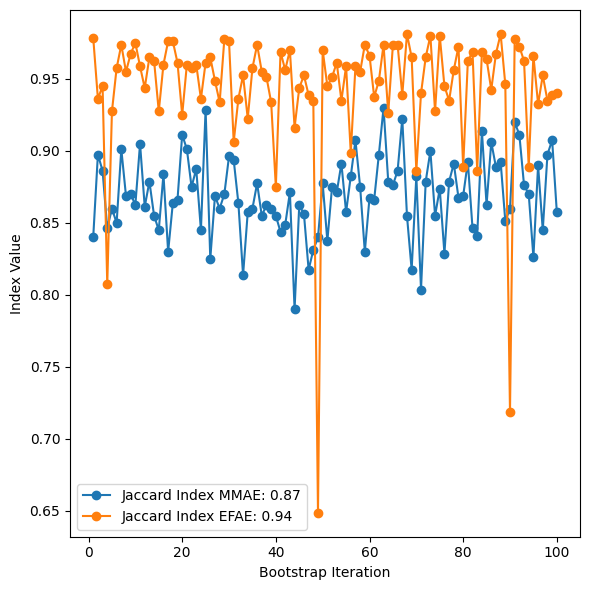

In [18]:
plt.style.use('default')
# Perform cluster stability analysis using Spectral
labels_ = ['mm_Agglomerative']
jaccard_indices_mm = clustering_helpers.cluster_stability(latent_mm, all_labels[labels_][labels_[0]].values, 40, 'agglomerative', num_iterations=100)
mean_jaccard_mm = np.mean(jaccard_indices_mm)

labels_ = ['lf_Agglomerative']
# Perform cluster stability analysis using KMeans
jaccard_indices_lf = clustering_helpers.cluster_stability(latent_late_fusion, all_labels[labels_][labels_[0]].values, 3, 'agglomerative', num_iterations=100)
mean_jaccard_lf = np.mean(jaccard_indices_lf)

# Plotting ARI and Jaccard Index across the runs
plt.figure(figsize=(6, 6))
plt.plot(range(1, len(jaccard_indices_mm) + 1), jaccard_indices_mm, label="Jaccard Index MMAE: {0:.2}".format(mean_jaccard_mm), marker='o')
plt.plot(range(1, len(jaccard_indices_lf) + 1), jaccard_indices_lf, label="Jaccard Index EFAE: {0:.2}".format(mean_jaccard_lf) , marker='o')
plt.xlabel("Bootstrap Iteration")
plt.ylabel("Index Value")
plt.legend()
plt.tight_layout()

plt.show()

## KM

In [ ]:
folder_sepsis = 'sepsis3_queries/data'
sepsis3 = pd.read_csv(f'{folder_sepsis}/sepsis-df-3.csv')
sepsis3.set_index('icustay_id', inplace=True)


In [ ]:
all_labels.index = sepsis3.index




In [ ]:
labels_ = ['mm_Agglomerative']


sns.set(style="darkgrid", palette="colorblind", color_codes=True)



for modality in labels_:
    kmd = sepsis3.join(all_labels[modality])
    surv = SurvivalData(time="icu_los", status="mort_icu", group=modality, data=kmd)
    print(kmd.groupby(modality)['mort_icu'].value_counts())

    #observed lifetimes of all the individuals in the data. Censored individuals are marked at the end of their lifespan.
    plt.figure(figsize=(20, 16))
    surv.plot_lifetimes()
    plt.title(modality)
    plt.show()
    plt.close()

    #kaplan meier
    km = KaplanMeier()
    km.fit(surv)

    #display(km.summary())
    # abulates the survival probability estimates and thier 
    # standard error and confidence intervals for the event times within each group. 
    # It can be printed to display all the information at once.
    #print(km.summary)
    plt.figure(figsize=(20, 16))
    km.plot()
    plt.title(modality)
    plt.show()
    plt.close()


    estimate = km.predict([1, 3, 5, 10, 30])
    # estimated probabiltiies for surviving past a certain time for each group.
    print(modality)
    display(estimate)

## Heatmaps

In [ ]:
time_series_3d_df = pd.read_csv('preprocessing/representations/time_series_3d.csv')
time_series_3d_df = time_series_3d_df.set_index('icustay_id')
temp = time_series_3d_df.join(all_labels[labels_])
features_to_plot = ['heartrate', 'sysbp']


clustering_helpers.plot_hourly_means_by_label(temp, features_to_plot, label_column=labels_[0])


In [ ]:
import pandas as pd
from scipy.stats import pointbiserialr, pearsonr


def calculate_cluster_correlation_multiple_features(df, cluster_column, feature_columns, mortality_df, mortality_columns):
    """
    Calculate the cluster average values of multiple features and their point-biserial correlation with binary mortality outcomes.

    Args:
        df (pd.DataFrame): Input dataframe containing cluster information, features, and binary mortality outcomes.
        cluster_column (str): Name of the column containing cluster labels.
        feature_columns (list): List of column names containing features.
        mortality_df (pd.DataFrame): DataFrame containing mortality information with the same row IDs as 'df'.
        mortality_columns (list): List of column names containing binary mortality outcomes.

    Returns:
        pd.DataFrame: DataFrame containing cluster labels, average feature values, and point-biserial correlation with mortality outcomes.
    """
    # Merge mortality information into the analysis DataFrame
    merged_df = pd.merge(df, mortality_df, left_index=True, right_index=True)

    # Create an empty DataFrame to store results
    result_df = pd.DataFrame(columns=[cluster_column] + feature_columns + mortality_columns)

    # Iterate over unique clusters
    for cluster_label in merged_df[cluster_column].unique():
        # Filter dataframe for the current cluster
        cluster_df = merged_df[merged_df[cluster_column] == cluster_label]

        # Calculate average values for each feature in the cluster
        avg_values = cluster_df[feature_columns].mean()

        # Replace NaN values with the mean of the column
        cluster_df[feature_columns] = cluster_df[feature_columns].apply(lambda col: col.fillna(col.mean()))

        # Calculate point-biserial correlation with each binary mortality outcome
        # correlations = [pointbiserialr(cluster_df[feature_column], cluster_df[mortality_column])[0] for feature_column in feature_columns for mortality_column in mortality_columns]
        # pvalue = [pointbiserialr(cluster_df[feature_column], cluster_df[mortality_column])[1] for feature_column in feature_columns for mortality_column in mortality_columns]
        # Calculate Pearson correlation with each binary mortality outcome for each feature
        correlations = [
            pearsonr(cluster_df[feature_column], cluster_df[mortality_column])[0]
            for feature_column in feature_columns
            for mortality_column in mortality_columns
        ]
        pvalue = [
            pearsonr(cluster_df[feature_column], cluster_df[mortality_column])[1]
            for feature_column in feature_columns
            for mortality_column in mortality_columns
        ]
        # # Create a row for the result DataFrame
        result_row = pd.DataFrame([[cluster_label] + list(avg_values.values) + correlations + pvalue], columns=[cluster_column] + feature_columns + mortality_columns + \
                                  ['pvalue_hosp'] + ['pvalue_30'] + ['pvalue_inicu']+['pvalue_inhosp'])
        #result_row = pd.DataFrame([avg_values.tolist() + correlations], columns=feature_columns + mortality_columns*len(feature_columns))

        # Append the result row to the result DataFrame
        result_df = result_df.append(result_row, ignore_index=True)
        # Round values in both columns to three decimal places
        result_df['pvalue_hosp'] = result_df['pvalue_hosp'].round(3)
        result_df['pvalue_30'] = result_df['pvalue_30'].round(3)
        result_df['pvalue_inicu'] = result_df['pvalue_inicu'].round(3)
        result_df['pvalue_inhosp'] = result_df['pvalue_inhosp'].round(3)

    return result_df

# Example usage:
# Assuming you have a DataFrame 'your_dataframe' with columns: 'ClusterLabel', 'Feature1', 'Feature2', ..., 'InICUMortality', 'InHospitalMortality', '30DayMortality'
feature_columns_to_check = ['bun']
mortality_columns_to_check = ['hospital_expire_flag', 'thirtyday_expire_flag', 'mort_icu', 'mort_hosp']
result = calculate_cluster_correlation_multiple_features(temp, labels_[0], feature_columns_to_check, sepsis3, mortality_columns_to_check)
result

## Cluster size, age and outcome characteristics.

In [ ]:
sepsis3.columns

In [ ]:
from tableone import TableOne
sepsis3temp1 = sepsis3[['age', 'gender',
       'race_white', 'weight',
       'bmi','hospital_expire_flag', 'thirtyday_expire_flag', 'mort_icu',
       'icu_los', 'hosp_los']]

sepsis3temp1 = sepsis3temp1.join(all_labels[labels_])
table1_sepsis3 = TableOne(sepsis3temp1, groupby=labels_, missing=False, tukey_test=True, normal_test=True,display_all=True)
table1_sepsis3

In [ ]:
diagnoses_at_admission = sepsis3[[
    'diagnosis'
]]

diagnoses_at_admission = diagnoses_at_admission.join(all_labels[labels_])

diagnoses_at_admission.groupby('mm_Agglomerative').value_counts().reset_index(name='count').groupby('mm_Agglomerative').head(6).set_index('mm_Agglomerative')

# table2_sepsis3 = TableOne(sepsis3temp2, groupby=labels_, missing=False, tukey_test=True, normal_test=True,display_all=True)
# table2_sepsis3

In [ ]:
diagnoses = pd.read_csv(f'{folder_sepsis}/diagnoses.csv')
diagnoses = diagnoses[diagnoses.hadm_id.isin(sepsis3.hadm_id)]
sepsis3 = sepsis3.join(all_labels[labels_])
sepsis3 = sepsis3.reset_index().set_index('hadm_id')
diagnoses = diagnoses.set_index('hadm_id')
diagnoses = diagnoses.join(sepsis3)
sepsis3 = sepsis3.reset_index().set_index('icustay_id')

diagnoses = diagnoses.reset_index().set_index('icustay_id')
diagnoses = diagnoses[['icd9_code', 'icd9_title', 'mm_Agglomerative']]
# Mapping dictionary with ranges
icd9_mapping = {
    'Infectious and Parasitic Diseases': ('001', '139'),
    'Neoplasms': ('140', '239'),
    'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders': ('240', '279'),
    'Diseases of the Blood and Blood-Forming Organs': ('280', '289'),
    'Mental Disorders': ('290', '319'),
    'Diseases of the Nervous System and Sense Organs': ('320', '389'),
    'Diseases of the Circulatory System': ('390', '459'),
    'Diseases of the Respiratory System': ('460', '519'),
    'Diseases of the Digestive System': ('520', '579'),
    'Diseases of the Genitourinary System': ('580', '629'),
    'Complications of Pregnancy, Childbirth, and the Puerperium': ('630', '679'),
    'Diseases of the Skin and Subcutaneous Tissue': ('680', '709'),
    'Diseases of the Musculoskeletal System and Connective Tissue': ('710', '739'),
    'Congenital Anomalies': ('740', '759'),
    'Certain Conditions Originating in the Perinatal Period': ('760', '779'),
    'Symptoms, Signs, and Ill-Defined Conditions': ('780', '799'),
    'Injury and Poisoning': ('800', '999'),
    'External Causes of Injury and Supplemental Classification': ('E00', 'V99')
}
diagnoses['upper_hierarchy'] = diagnoses['icd9_code'].str[:3]
# Check if icd9_code falls within the specified range for each category
for category, (lower, upper) in icd9_mapping.items():
    diagnoses[category] = diagnoses['upper_hierarchy'].between(lower, upper)

diagnoses['Combinedicd9'] = diagnoses.apply(lambda row: ' '.join(row.iloc[4:].index[row.iloc[4:]]), axis=1)
diagnoses = diagnoses[['icd9_code',	'icd9_title',	'mm_Agglomerative',	'upper_hierarchy', 'Combinedicd9']]
freq_diagnoses = diagnoses.groupby('icustay_id').Combinedicd9.value_counts().reset_index(name='count').groupby('icustay_id').head(1).set_index('icustay_id')
freq_diagnoses = freq_diagnoses.join(diagnoses['mm_Agglomerative'])
freq_diagnoses =freq_diagnoses.drop_duplicates()
freq_diagnoses.drop('count', axis=1).groupby('mm_Agglomerative').value_counts().reset_index(name='count').groupby('mm_Agglomerative').head(2).set_index('mm_Agglomerative')


In [ ]:
sepsis3.columns

In [ ]:
sepsis3.groupby(labels_).sirs.mean()

In [ ]:
sepsis3.groupby(labels_).sofa.mean()

In [ ]:
sepsis3.groupby(labels_).elixhauser_hospital.value_counts()

In [ ]:
sepsis3.groupby(labels_).qsofa.mean()

In [ ]:
temp = sepsis3[['elixhauser_hospital', 'vent',
       'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score', 'qsofa_gcs_score',
       'qsofa_resprate_score', 'mm_Agglomerative']]
table = TableOne(temp, groupby= labels_, pval = True,pval_adjust='bonferroni', smd=False,
                  htest_name=True, display_all=True)
table 

## Table 1

In [ ]:
all_labels.columns

In [ ]:


ts_2d_df = pd.read_csv('preprocessing/representations/time_series_2d.csv')
ts_2d_df = ts_2d_df.set_index('icustay_id')


hd_labels = all_labels[labels_]
hd_labels.index = ts_2d_df.index

temp = ts_2d_df.join(hd_labels)

table1 = TableOne(temp, dip_test=True, normal_test=True, tukey_test=True)
table1

In [ ]:
nonnormal = list(temp.columns)
table2 = TableOne(temp, groupby= labels_,  nonnormal=nonnormal, pval = True, pval_adjust='bonferroni', smd=False,
                  htest_name=True)

table2

In [ ]:
t2 = table2.tableone
t2.columns = t2.columns.droplevel()
t2 = t2.replace(to_replace='<', value='', regex=True)

t2["P-Value (adjusted)"] = pd.to_numeric(t2["P-Value (adjusted)"], errors='coerce', downcast="float")

t2[t2['P-Value (adjusted)']<=0.05]

In [ ]:
#static = static.set_index('icustay_id')
temp = static.join(hd_labels)


table = TableOne(temp, groupby= labels_, pval = True,pval_adjust='bonferroni', smd=False,
                  htest_name=True, display_all=True)
table 

In [ ]:
all_labels[labels_].value_counts()

## Spider plots

In [ ]:
def create_spider_plot(categories, values, cluster_names):
    """
    Create a spider plot to visualize cluster counts for different variables.

    Parameters:
    - categories (list): List of variable categories.
    - values (list of arrays): Cluster values for each category.
    - cluster_names (list): Names for different clusters.

    Returns:
    None

    Example:
    create_spider_plot(
        categories=['Category1', 'Category2', 'Category3'],
        values=[[10, 15, 20], [5, 10, 15]],
        cluster_names=['Cluster A', 'Cluster B']
    )
    """
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    values = np.array(values)
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})
    plt.xticks(angles, categories)

    for i, (cluster_name, cluster_values) in enumerate(zip(cluster_names, values)):
        ax.plot(angles, cluster_values, label=cluster_name)
        ax.fill(angles, cluster_values, alpha=0.25)

    ax.set_yticklabels([])
    ax.legend()
    plt.title("Cluster Counts for Each Variable")
    plt.show()

In [ ]:
best_labels.index = static.index
static.join(best_labels[labels_]).groupby(labels_).sum()


In [ ]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[:, :][['race_white', 'F', 'M', 'adults', 'seniors']]
#iloc[[3,4,9,10], :]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['vent', 'gcs_13_15', 'gcs_9_12',
       'gcs_<8']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[11, 13, 4, 6, 7, 10 ], :][['race_white', 'F', 'M', 'adults', 'seniors']]
#iloc[[3,4,9,10], :]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[11, 13, 4, 6, 7, 10 ], :][['vent', 'gcs_13_15', 'gcs_9_12',
       'gcs_<8']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['circulatory', 'mental', 'circulatory_infectious_congenital',
       'nervous_and_sense', 'endocrinal_nutritional', 'neoplasms',
       'blood_and_blood_forming']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['congestive_heart_failure', 'cardiac_arrhythmias', 
        'hypertension', 'other_neurological',
       'chronic_pulmonary', 'diabetes', 'renal_failure',
       'liver_disease', 'coagulopathy', 'fluid_electrolyte',
       'alcohol_abuse', 'depression']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
best_labels[labels_].value_counts()
temp_ = time_series_2d_df

In [ ]:
temp = temp_.join(best_labels[labels_]).groupby(labels_).mean().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['heartrate', 'meanbp', 'resprate', 'sysbp', 'diasbp', ]]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:

temp = temp_.join(best_labels[labels_]).groupby(labels_).mean().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['hematocrit', 'hemoglobin', 'platelet', 'ptt', 'wbc', 'tempc' ]]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = temp_.join(best_labels[labels_]).groupby(labels_).mean().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['bicarbonate', 'chloride', 'glucose',  'sodium',
       'potassium', 'creatinine', 'urineoutput', 'lactate']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)